In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat as loadmat
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

# Suppress warnings`
warnings.filterwarnings("ignore")

In [2]:
import xy

# $因子描述：耀眼波动率因子（Sparkling Sigma）$

***选取过去二十日中，高波动时段内的收益率，并计算这些时段上收益率的波动率。***  
对于日内放量的时段，这些时段上收益率的波动

1. 数据：标的日内分钟行情（**对于指数因子，此处采用指数分钟行情**）  
2. 计算标的每个交易日中间220分钟当中，涨幅最大的分钟收益率 
3. 对2.的结果取20日均值

$参考报告：《20201012-长江证券-基础因子研究（十四）：高频因子（九），高频波动中的时间序列信息》$

![示例](sample.jpg)

## 计算

In [218]:
def Picking_VOL_Wired_idx(x):
    mean = np.nanmean(x)
    std = np.nanstd(x,ddof=1)

    return np.where(x>=(mean+0.5*std),1,np.nan)

def cal_SPS(index_min):
    index_min.Date = index_min.Date.astype('datetime64[ns]')
    index_min.Date = pd.to_datetime(index_min.Date)
    
    preclose = index_min.close.shift(240)[239::240].values
    index_min['preclose'] = np.tile(preclose,(240,1)).T.reshape(-1)
    index_min = index_min.dropna() 
    
    display(index_min)
    # display(index_min.close.shift(240)[239::240],index_min)
    SPS = {}
    count = 0
    
    for d, _df in tqdm(index_min.groupby(index_min['Date'].dt.date)):
        
        if np.isnan(_df['preclose'].values[0]):
            
            count += 1
            continue
        
        _df.index = _df.Date
        vol_chg = _df.money[10:-10]
        
        pcl = preclose[count]
        # ret_now = (_df.close - pcl) / pcl
        ret_now = _df.close.pct_change()[10:-10]
        VOL_Wired_idx = Picking_VOL_Wired_idx(vol_chg)

        row_stds = []

        for num, i in enumerate(VOL_Wired_idx):
            if i == 1:
                if len(ret_now[num:num+5]) <5:
                    continue
                ret_std = np.nansum(ret_now[num:num+5])#,ddof=1
                row_stds.append(ret_std)
                
        spk_std = np.nanstd(row_stds)
        SPS[ str(ret_now.index[0])[:10]] = spk_std
        
        count += 1

    return pd.Series(SPS)

In [219]:
SPS50 = cal_SPS(xy.ETFMin50jq.reset_index().rename(columns={'index':'Date'}))
SPS300 = cal_SPS(xy.ETFMin300jq.reset_index().rename(columns={'index':'Date'}))
SPS500 = cal_SPS(xy.ETFMin500jq.reset_index().rename(columns={'index':'Date'}))
SPS1000 = cal_SPS(xy.ETFMin1000jq.loc['2015-01-05':].reset_index().rename(columns={'index':'Date'}))

,Date,open,close,high,low,volume,money,preclose
240,2009-01-06 09:31:00,0.939,0.942,0.942,0.938,7201434.0,8180411.0,0.944
241,2009-01-06 09:32:00,0.942,0.940,0.942,0.940,473383.0,538593.0,0.944
242,2009-01-06 09:33:00,0.941,0.942,0.943,0.940,5010190.0,5701814.0,0.944
243,2009-01-06 09:34:00,0.942,0.943,0.943,0.942,1594704.0,1816870.0,0.944
244,2009-01-06 09:35:00,0.943,0.943,0.944,0.943,3413251.0,3893174.0,0.944
...,...,...,...,...,...,...,...,...
838795,2023-05-23 14:56:00,2.622,2.621,2.623,2.621,15025000.0,39382795.0,2.659
838796,2023-05-23 14:57:00,2.621,2.620,2.622,2.620,11413000.0,29906478.0,2.659
838797,2023-05-23 14:58:00,2.620,2.620,2.622,2.620,21223200.0,55602821.0,2.659
838798,2023-05-23 14:59:00,2.620,2.619,2.620,2.619,11394500.0,29842275.0,2.659


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3494/3494 [00:11<00:00, 309.80it/s]


,Date,open,close,high,low,volume,money,preclose
197760,2012-05-29 09:31:00,2.200,2.202,2.202,2.200,9745928.0,21455530.0,2.201
197761,2012-05-29 09:32:00,2.202,2.202,2.203,2.201,3487674.0,7680776.0,2.201
197762,2012-05-29 09:33:00,2.202,2.203,2.203,2.202,668965.0,1473110.0,2.201
197763,2012-05-29 09:34:00,2.202,2.203,2.203,2.202,2204142.0,4855372.0,2.201
197764,2012-05-29 09:35:00,2.203,2.204,2.204,2.203,4582236.0,10096116.0,2.201
...,...,...,...,...,...,...,...,...
838795,2023-05-23 14:56:00,3.910,3.910,3.911,3.910,23230400.0,90814672.0,3.964
838796,2023-05-23 14:57:00,3.910,3.909,3.910,3.909,14243100.0,55677442.0,3.964
838797,2023-05-23 14:58:00,3.909,3.909,3.910,3.909,10152100.0,39685694.0,3.964
838798,2023-05-23 14:59:00,3.909,3.909,3.910,3.908,11880400.0,46432066.0,3.964


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2671/2671 [00:08<00:00, 321.25it/s]


,Date,open,close,high,low,volume,money,preclose
244560,2013-03-18 09:31:00,2.975,3.012,3.018,2.975,99134.0,298177.0,3.022
244561,2013-03-18 09:32:00,3.012,2.993,3.012,2.993,73933.0,222713.0,3.022
244562,2013-03-18 09:33:00,3.012,3.012,3.012,3.012,146389.0,440952.0,3.022
244563,2013-03-18 09:34:00,3.012,3.012,3.012,3.012,50305.0,151480.0,3.022
244564,2013-03-18 09:35:00,3.012,3.012,3.012,3.012,22472.0,67690.0,3.022
...,...,...,...,...,...,...,...,...
838795,2023-05-23 14:56:00,6.095,6.095,6.096,6.094,747400.0,4555564.0,6.149
838796,2023-05-23 14:57:00,6.095,6.094,6.096,6.094,671900.0,4095438.0,6.149
838797,2023-05-23 14:58:00,6.093,6.089,6.093,6.089,640700.0,3903256.0,6.149
838798,2023-05-23 14:59:00,6.088,6.085,6.088,6.083,1271700.0,7737261.0,6.149


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2476/2476 [00:06<00:00, 360.95it/s]


,Date,open,close,high,low,volume,money,preclose
107520,2016-11-07 09:31:00,2.766,2.769,2.769,2.766,61720.0,170840.0,2.766
107521,2016-11-07 09:32:00,2.769,2.769,2.772,2.769,28314.0,78409.0,2.766
107522,2016-11-07 09:33:00,2.769,2.769,2.772,2.769,38282.0,106001.0,2.766
107523,2016-11-07 09:34:00,2.769,2.769,2.769,2.769,17155.0,47500.0,2.766
107524,2016-11-07 09:35:00,2.766,2.766,2.766,2.766,7584.0,20980.0,2.766
...,...,...,...,...,...,...,...,...
489355,2023-05-23 14:56:00,2.616,2.617,2.617,2.616,1797000.0,4701550.0,2.635
489356,2023-05-23 14:57:00,2.617,2.616,2.617,2.616,1577100.0,4126309.0,2.635
489357,2023-05-23 14:58:00,2.616,2.615,2.617,2.615,751200.0,1965027.0,2.635
489358,2023-05-23 14:59:00,2.615,2.612,2.615,2.611,857300.0,2240751.0,2.635


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1591/1591 [00:03<00:00, 440.17it/s]


In [105]:
# 参数平滑
ETFKURScountjq_s01 = pd.concat([
    index_kur_ex10_s(xy.ETFMin50jq.loc['2016-01-28':].volume,0.1).rename('50'),
    index_kur_ex10_s(xy.ETFMin300jq.loc['2016-01-28':].volume,0.1).rename('300'),
    index_kur_ex10_s(xy.ETFMin500jq.loc['2016-01-28':].volume,0.1).rename('500'),
    index_kur_ex10_s(xy.ETFMin1000jq.loc['2016-01-28':].volume,0.1).rename('1000'),
    index_kur_ex10_s(xy.ETFMin100sz_jq.loc['2016-01-28':].volume,0.1).rename('100sz'),
    index_kur_ex10_s(xy.ETFMin50kc_jq.loc['2016-01-28':].volume,0.1).rename('50kc'),
    index_kur_ex10_s(xy.ETFMin2000jq.loc['2016-01-28':].volume,0.1).rename('2000')
],axis=1).shift(1)

ETFKURScountjq_s02 = pd.concat([
    index_kur_ex10_s(xy.ETFMin50jq.loc['2016-01-28':].volume,0.2).rename('50'),
    index_kur_ex10_s(xy.ETFMin300jq.loc['2016-01-28':].volume,0.2).rename('300'),
    index_kur_ex10_s(xy.ETFMin500jq.loc['2016-01-28':].volume,0.2).rename('500'),
    index_kur_ex10_s(xy.ETFMin1000jq.loc['2016-01-28':].volume,0.2).rename('1000'),
    index_kur_ex10_s(xy.ETFMin100sz_jq.loc['2016-01-28':].volume,0.2).rename('100sz'),
    index_kur_ex10_s(xy.ETFMin50kc_jq.loc['2016-01-28':].volume,0.2).rename('50kc'),
    index_kur_ex10_s(xy.ETFMin2000jq.loc['2016-01-28':].volume,0.2).rename('2000')
],axis=1).shift(1)

ETFKURScountjq_s03 = pd.concat([
    index_kur_ex10_s(xy.ETFMin50jq.loc['2016-01-28':].volume,0.3).rename('50'),
    index_kur_ex10_s(xy.ETFMin300jq.loc['2016-01-28':].volume,0.3).rename('300'),
    index_kur_ex10_s(xy.ETFMin500jq.loc['2016-01-28':].volume,0.3).rename('500'),
    index_kur_ex10_s(xy.ETFMin1000jq.loc['2016-01-28':].volume,0.3).rename('1000'),
    index_kur_ex10_s(xy.ETFMin100sz_jq.loc['2016-01-28':].volume,0.3).rename('100sz'),
    index_kur_ex10_s(xy.ETFMin50kc_jq.loc['2016-01-28':].volume,0.3).rename('50kc'),
    index_kur_ex10_s(xy.ETFMin2000jq.loc['2016-01-28':].volume,0.3).rename('2000')
],axis=1).shift(1)

ETFKURScountjq_s04 = pd.concat([
    index_kur_ex10_s(xy.ETFMin50jq.loc['2016-01-28':].volume,0.4).rename('50'),
    index_kur_ex10_s(xy.ETFMin300jq.loc['2016-01-28':].volume,0.4).rename('300'),
    index_kur_ex10_s(xy.ETFMin500jq.loc['2016-01-28':].volume,0.4).rename('500'),
    index_kur_ex10_s(xy.ETFMin1000jq.loc['2016-01-28':].volume,0.4).rename('1000'),
    index_kur_ex10_s(xy.ETFMin100sz_jq.loc['2016-01-28':].volume,0.4).rename('100sz'),
    index_kur_ex10_s(xy.ETFMin50kc_jq.loc['2016-01-28':].volume,0.4).rename('50kc'),
    index_kur_ex10_s(xy.ETFMin2000jq.loc['2016-01-28':].volume,0.4).rename('2000')
],axis=1).shift(1)

ETFKURScountjq_s = (ETFKURScountjq_s01+ETFKURScountjq_s02+ETFKURScountjq_s03+ETFKURScountjq_s04) / 4

NameError: name 'index_kur_ex10_s' is not defined

In [220]:
_SPS = pd.concat([
    SPS50.rename('50'),
    SPS300.rename('300'),
    SPS500.rename('500'),
    SPS1000.rename('1000')
],axis=1).shift(1).dropna(how='all')

In [47]:
# ETFKURScountjq_s.T.to_csv('../NewFactor/Kur_idxETF.csv')

## 评估

### cl-cl

0.0018979160505684883
1 0.8926136363636363
2 1.0
3 1.0
4 1.0


<Axes: >

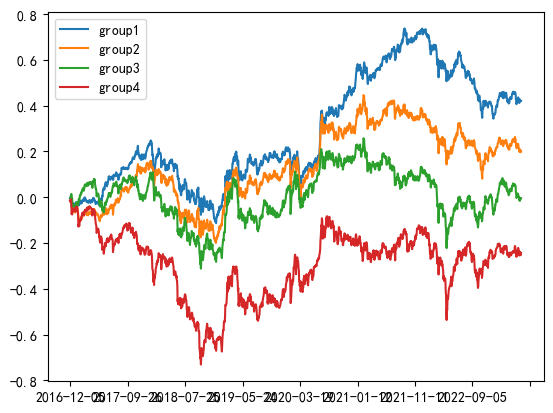

In [223]:
# 分组收益率
gr_SPS = xy.cal_rate_group(
    _SPS.rolling(20).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    group_num=4,
    masks=1
)
gr_SPS.dropna().cumsum().plot()

288.0
yoy: -0.0918584754769515 
 mdd: -1.0571723415006153 
 sharpe: -0.5978758145952684 
 rankIC: -0.002753037687097743 
 rankIR: -0.0039069120075824835 
 win%: 0.4954545454545455 
 gain_loss%: -0.9179501325207052


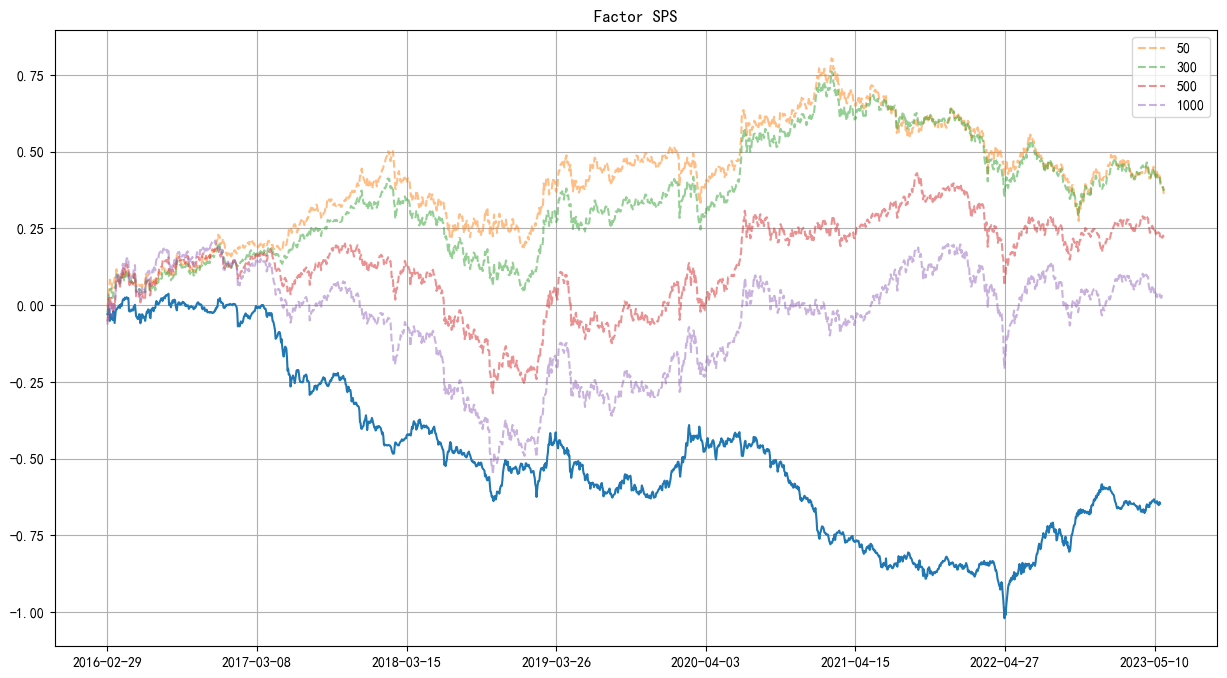

In [224]:
# 单因子强弱
SPS_select, SPS_rets = xy.single_Factor_backtest(
    _SPS.rolling(20).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=1,
    fee=0.000,
    name='SPS'
)

-0.002753037687097743

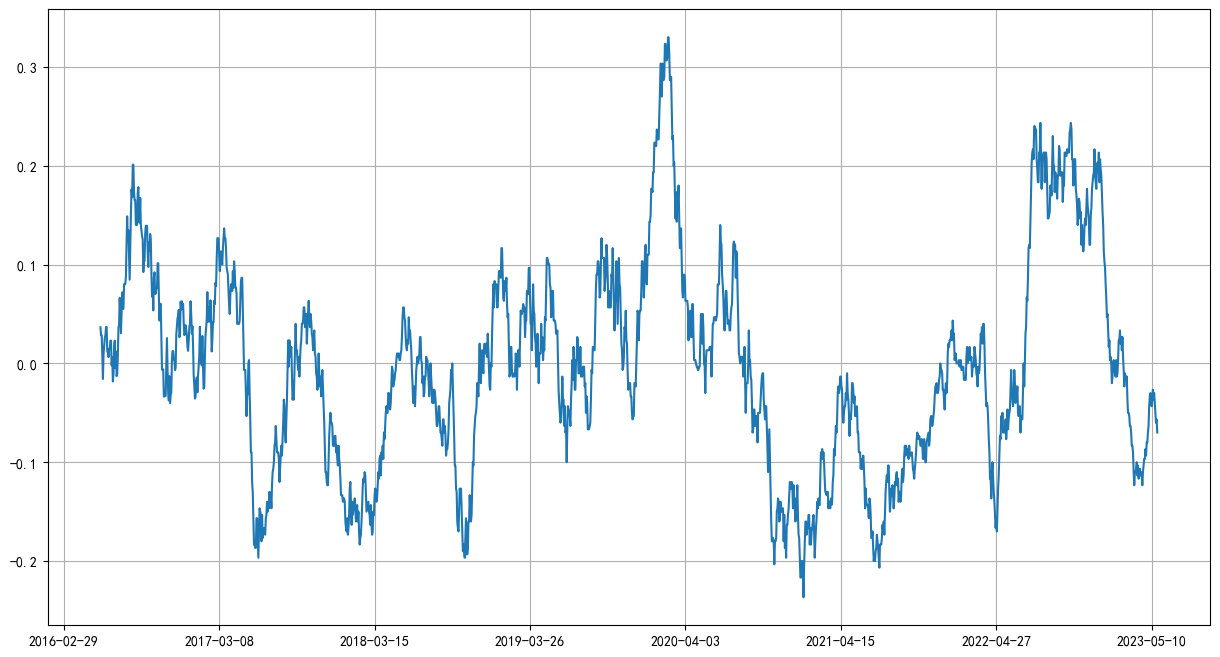

In [225]:
# 因子截面IC趋势
rankIC = xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False).corrwith(_SPS.rolling(20).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()

### cl_op

-0.1842812191997877
1 0.8926136363636363
2 1.0
3 1.0
4 1.0


<Axes: >

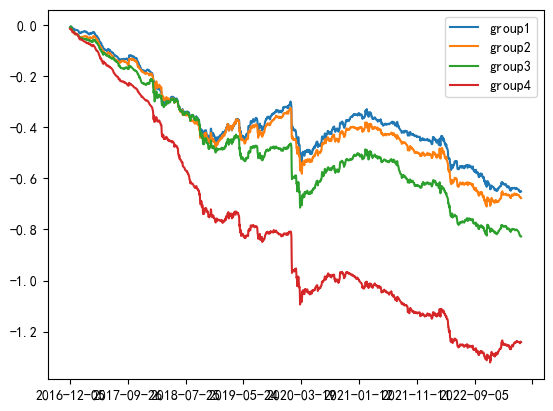

In [234]:
# 分组收益率
gr_SPS = xy.cal_rate_group(
    _SPS.rolling(20).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    group_num=4,
    masks=1
)
gr_SPS.dropna().cumsum().plot()

In [235]:
# 单调性处理
new_EXR = xy.linear_projector(gr_EXR, _EXR.rolling(1).mean().T, 60)

NameError: name 'gr_EXR' is not defined

0.17611096421837175
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

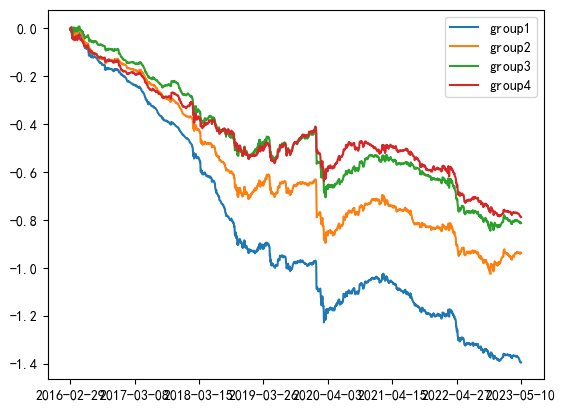

In [223]:
# 分组收益率
gr_new_EXR = xy.cal_rate_group(
    new_EXR.T.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    group_num=4,
    masks=1
)
gr_new_EXR.dropna().cumsum().plot()

288.0
yoy: 0.08577495196204858 
 mdd: -0.11676478064700968 
 sharpe: 1.9885106946852111 
 rankIC: -0.11700685583186327 
 rankIR: -0.17378998089568973 
 win%: 0.5767045454545454 
 gain_loss%: -1.0836136322720515


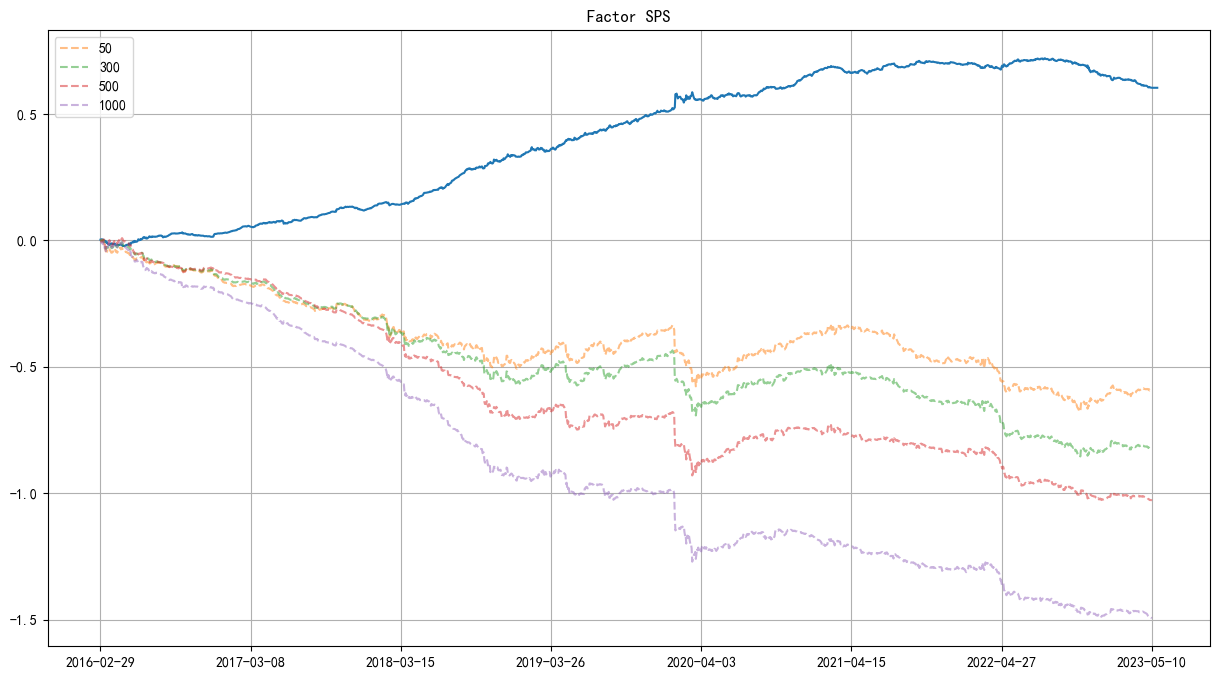

In [236]:
# 单因子强弱
SPS_select, SPS_rets = xy.single_Factor_backtest(
    _SPS.rolling(20).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=-1,
    fee=0.000,
    name='SPS'
)

-0.0874779541446208

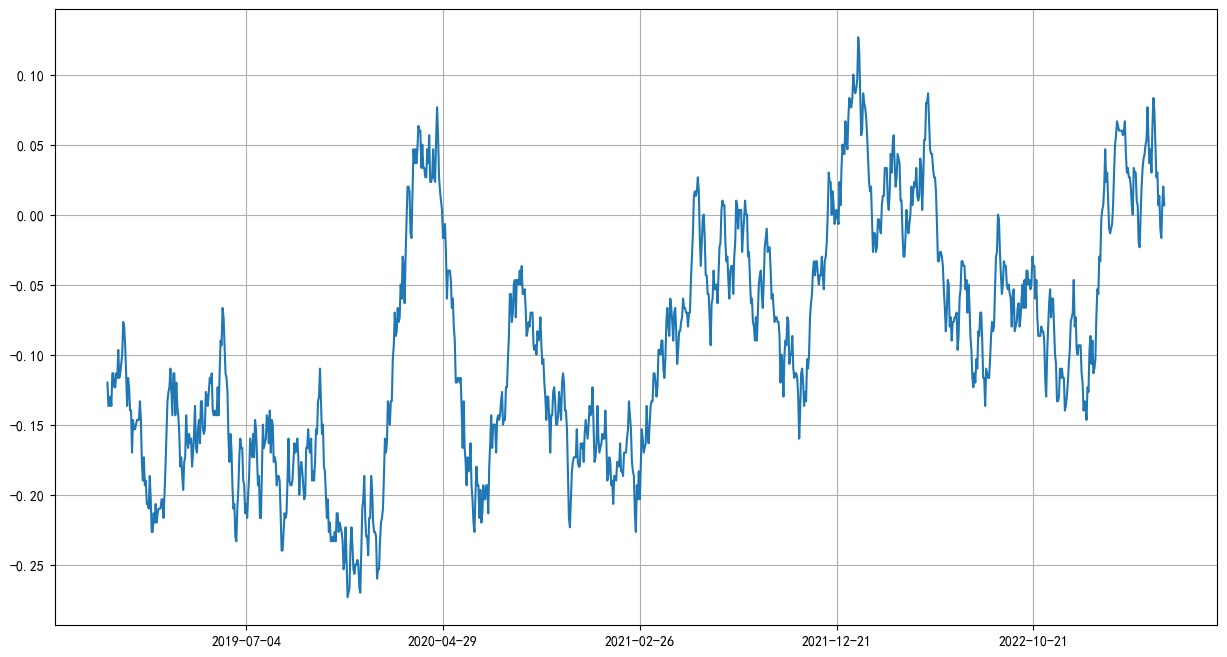

In [237]:
# 因子截面IC趋势
rankIC = xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2018-09-03':].rank(ascending=False).corrwith(_SPS.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()

In [239]:
_SPS.rolling(20).mean().T.loc[['50', '300', '500', '1000'],:].dropna(how='all',axis=1).to_csv(r'E:\PyProject\factors\NewFactor\idx_SPS_ETF_tail.csv')